In [1]:
#libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import numpy as np
import os

from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from keras.layers import Dense, Input, Flatten, Reshape
#from keras.layers import Conv1D, MaxPooling1D, Embedding, Merge, Dropout, LSTM, GRU, Bidirectional, concatenate
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional, Concatenate, GlobalAveragePooling2D, Input, Lambda, AveragePooling1D
from keras.applications.densenet import preprocess_input, DenseNet121
from keras.models import Model, Sequential
from keras.utils import to_categorical

from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import optimizers
from keras import regularizers
from keras.utils.layer_utils import print_summary
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import CSVLogger
import warnings


Using TensorFlow backend.


In [2]:
img_size = 256
batch_size = 16
VALIDATION_SPLIT = 0.2
TEST_SPLIT = 0.2

#Measure of success
def kappa(y_true, y_pred):
    y_true = np.argmax(y_true, axis = 1)
    y_pred = np.argmax(y_pred, axis = 1)
    
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

In [3]:
breeds = pd.read_csv('./all/breed_labels.csv')
colors = pd.read_csv('./all/color_labels.csv')
states = pd.read_csv('./all/state_labels.csv')
train = pd.read_csv('./all/train.csv')
test = pd.read_csv('./all/test/test.csv')

In [4]:
pet_ids = train['PetID'].values
n_batches = len(pet_ids) // batch_size + 1

### Get 256 image features for each pet

Don't need to run the model now. Directly load the csv features. Later, we could use a different pre-trained model or even re-train few layers.

In [ ]:
# def resize_to_square(im):
#     old_size = im.shape[:2] # old_size is in (height, width) format
#     ratio = float(img_size)/max(old_size)
#     new_size = tuple([int(x*ratio) for x in old_size])
#     # new_size should be in (width, height) format
#     im = cv2.resize(im, (new_size[1], new_size[0]))
#     delta_w = img_size - new_size[1]
#     delta_h = img_size - new_size[0]
#     top, bottom = delta_h//2, delta_h-(delta_h//2)
#     left, right = delta_w//2, delta_w-(delta_w//2)
#     color = [0, 0, 0]
#     new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
#     return new_im

# def load_image(path, pet_id):
#     image = cv2.imread(f'{path}{pet_id}-1.jpg')
#     new_image = resize_to_square(image)
#     new_image = preprocess_input(new_image)
#     return new_image

# inp = Input((256,256,3))
# backbone = DenseNet121(input_tensor = inp, include_top = False)
# x = backbone.output
# x = GlobalAveragePooling2D()(x)
# x = Lambda(lambda x: K.expand_dims(x,axis = -1))(x)
# x = AveragePooling1D(4)(x)
# out = Lambda(lambda x: x[:,:,0])(x)

# m = Model(inp,out)

# features = {}
# for b in (range(n_batches)):
#     start = b*batch_size
#     end = (b+1)*batch_size
#     batch_pets = pet_ids[start:end]
#     batch_images = np.zeros((len(batch_pets),img_size,img_size,3))
#     for i,pet_id in enumerate(batch_pets):
#         try:
#             batch_images[i] = load_image("all/train_images/", pet_id)
#         except:
#             pass
#     batch_preds = m.predict(batch_images)
#     for i,pet_id in enumerate(batch_pets):
#         features[pet_id] = batch_preds[i]

# train_feats = pd.DataFrame.from_dict(features, orient='index')

# train_feats.to_csv('test_feats = pd.DataFrame.from_dict(features, orient='index')
# test_feats.to_csv('all/test/test_img_features.csv').csv')

# test_df = pd.read_csv('all/test/test.csv')
# pet_ids = test_df['PetID'].values
# n_batches = len(pet_ids) // batch_size + 1

# features = {}
# for b in tqdm_notebook(range(n_batches)):
#     start = b*batch_size
#     end = (b+1)*batch_size
#     batch_pets = pet_ids[start:end]
#     batch_images = np.zeros((len(batch_pets),img_size,img_size,3))
#     for i,pet_id in enumerate(batch_pets):
#         try:
#             batch_images[i] = load_image("all/test_images/", pet_id)
#         except:
#             pass
#     batch_preds = m.predict(batch_images)
#     for i,pet_id in enumerate(batch_pets):
#         features[pet_id] = batch_preds[i]

# test_feats = pd.DataFrame.from_dict(features, orient='index')
# test_feats.to_csv('all/test/test_img_features.csv')

In [5]:
train_feats = pd.read_csv('all/train_img_features.csv')
test_feats = pd.read_csv('all/test/test_img_features.csv')

In [6]:
print(train_feats.shape)
print(test_feats.shape)

(14993, 257)
(3948, 257)


In [7]:
#df = train_feats.iloc[:, 1:]
#train_feats = train_feats.drop(train_feats.columns[1:], axis = 1)
#train_feats['Img_data'] = df.apply(lambda x: np.array(x), axis=1)
#train_feats['Img_data'] = df.apply(lambda x: x.tolist(), axis=1)

#### Merge the image features with the categorical and numerical embeddings

In [8]:
train = train.merge(train_feats, left_on='PetID', right_on='Unnamed: 0', how='outer')
train.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,246,247,248,249,250,251,252,253,254,255
0,2,Nibble,3,299,0,1,1,7,0,1,...,0.787699,0.176625,0.575706,1.088627,0.439557,0.520460,1.547071,0.832572,0.599095,0.763349
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,0.628260,0.686865,0.563999,0.968190,1.070276,1.545739,0.894411,0.838595,0.468236,0.916672
2,1,Brisco,1,307,0,1,2,7,0,2,...,0.579116,0.557624,1.131405,0.720514,1.496672,0.870955,1.289682,1.184461,0.465113,0.892826
3,1,Miko,4,307,0,2,1,2,0,2,...,1.295853,0.326143,0.291668,1.608086,1.119176,1.470888,0.591445,0.832753,0.483021,1.134128
4,1,Hunter,1,307,0,1,1,0,0,2,...,1.092663,0.669893,0.395784,0.886075,1.219730,1.033964,1.065685,0.304053,0.438069,0.676818


### Encode tabular features

In [9]:
train_label = train.AdoptionSpeed
#We drop name because it creates a huge embedding vector and we know that name is not very useful anyway
train = train.drop(['AdoptionSpeed', 'Name', 'Description', 'PetID', 'Unnamed: 0', 'RescuerID'], axis=1)

In [10]:
#create train and test set
X_train, X_test, y_train, y_test = train_test_split(train, train_label, test_size=TEST_SPLIT, random_state=9)

#Turn labels into n dimensional vectors for loss calculation
y_train = to_categorical(y_train, num_classes=None)
y_test = to_categorical(y_test, num_classes=None)

In [11]:
categorical_vars = ['Type', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
        'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
        'Sterilized', 'Health', 'State']
numerical_vars = ['Age', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt']

In [12]:
def preproc(X_train, X_test, embed_cols, num_cols):

    input_list_train = []
    input_list_test = []
    m= MinMaxScaler()
        
    #the cols to be embedded: rescaling to range [0, # values)
    for c in embed_cols:
        raw_vals = np.unique(X_train[c])
        val_map = {}
        for i in range(len(raw_vals)):
            val_map[raw_vals[i]] = i       
        m.fit(X_train[c].map(val_map).values.reshape(-1, 1))
        input_list_train.append(m.transform(X_train[c].map(val_map).values.reshape(-1, 1)))
        
        m.fit(X_test[c].map(val_map).fillna(0).values.reshape(-1, 1))
        input_list_test.append(m.transform(X_test[c].map(val_map).fillna(0).values.reshape(-1, 1)))
        
    #the numerical columns
    m.fit(X_train[num_cols].values)
    input_list_train.append(m.transform(X_train[num_cols].values))
    
    m.fit(X_test[num_cols].values)
    input_list_test.append(m.transform(X_test[num_cols].values))
    
    #img data
    input_list_train.append(X_train.iloc[:, 19:].as_matrix())
    input_list_test.append(X_test.iloc[:, 19:].as_matrix())
    
    return input_list_train, input_list_test


#Creating a Embedding model for categorical variables using the fast.ai approach
def createModel(data, categorical_vars, numerical_vars):
    embeddings = []
    inputs = []
    for categorical_var in categorical_vars :
        i = Input(shape=(1,))
        model = Sequential()
        no_of_unique_cat  = data[categorical_var].nunique()
        embedding_size = min(np.ceil((no_of_unique_cat)/2), 50 )
        embedding_size = int(embedding_size)
        vocab  = no_of_unique_cat+1
        embedding = Embedding(vocab ,embedding_size, input_length = 1 )(i)
        embedding = Reshape(target_shape=(embedding_size,))(embedding)
        embeddings.append( embedding )
        inputs.append(i)
        
    input_numeric = Input(shape=(len(numerical_vars),))
    embedding_numeric = Dense(16)(input_numeric) 
    
    
    inputs.append(input_numeric)
    embeddings.append(embedding_numeric)
    
    x = Concatenate()(embeddings)
    x = Dense(50, activation='relu')(x)
    x = Dropout(.25)(x)
    x = Dense(30, activation='relu')(x)
    x = Dropout(.25)(x)
    
    #hardcoded for now
    image_input = Input(shape=(256,))
    inputs.append(image_input)
    
    y = Dense(80, activation='relu')(image_input)    
    y = Dense(40, activation='relu')(y)
    y = Dropout(.25)(y)
    
    z = Concatenate()([x, y])
    
    z = Dense(20, activation='relu')(z)
    
    output = Dense(5, activation='sigmoid')(z)

    model = Model(inputs, output)
    model.compile(metrics=['accuracy'], loss='categorical_crossentropy', optimizer='adam')
    return model

In [13]:
warnings.filterwarnings('ignore')
X_train, X_test = preproc(X_train, X_test, categorical_vars, numerical_vars)


In [14]:
model = createModel(train, categorical_vars, numerical_vars)
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_5 (I

### Now, we will train our model

In [15]:
filepath="checkpoints/weights_image_categorcial.hdf6"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
earlystopped = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=10, verbose=0, mode='max')
#callbacks_list = [checkpoint, earlystopped]
callbacks_list = [checkpoint]



In [16]:
hist = model.fit(X_train, y_train, batch_size=64 ,epochs=100, validation_split=VALIDATION_SPLIT, 
                 shuffle=True, callbacks=callbacks_list)

Train on 9595 samples, validate on 2399 samples
Epoch 1/100
9595/9595 [==============================] - 4s 432us/step - loss: 1.4746 - acc: 0.2713 - val_loss: 1.4485 - val_acc: 0.3201

Epoch 00001: val_acc improved from -inf to 0.32013, saving model to checkpoints/weights_image_categorcial.hdf6
Epoch 2/100
9595/9595 [==============================] - 2s 174us/step - loss: 1.4418 - acc: 0.3111 - val_loss: 1.4217 - val_acc: 0.3535

Epoch 00002: val_acc improved from 0.32013 to 0.35348, saving model to checkpoints/weights_image_categorcial.hdf6
Epoch 3/100
9595/9595 [==============================] - 2s 172us/step - loss: 1.4132 - acc: 0.3487 - val_loss: 1.3924 - val_acc: 0.3810

Epoch 00003: val_acc improved from 0.35348 to 0.38099, saving model to checkpoints/weights_image_categorcial.hdf6
Epoch 4/100
9595/9595 [==============================] - 2s 174us/step - loss: 1.3966 - acc: 0.3648 - val_loss: 1.3761 - val_acc: 0.3864

Epoch 00004: val_acc improved from 0.38099 to 0.38641, saving

9595/9595 [==============================] - 2s 184us/step - loss: 1.2790 - acc: 0.4366 - val_loss: 1.3405 - val_acc: 0.4073

Epoch 00039: val_acc did not improve from 0.42101
Epoch 40/100
9595/9595 [==============================] - 2s 167us/step - loss: 1.2812 - acc: 0.4391 - val_loss: 1.3362 - val_acc: 0.4131

Epoch 00040: val_acc did not improve from 0.42101
Epoch 41/100
9595/9595 [==============================] - 2s 177us/step - loss: 1.2761 - acc: 0.4372 - val_loss: 1.3425 - val_acc: 0.4135

Epoch 00041: val_acc did not improve from 0.42101
Epoch 42/100
9595/9595 [==============================] - 2s 169us/step - loss: 1.2743 - acc: 0.4443 - val_loss: 1.3491 - val_acc: 0.4114

Epoch 00042: val_acc did not improve from 0.42101
Epoch 43/100
9595/9595 [==============================] - 2s 170us/step - loss: 1.2722 - acc: 0.4348 - val_loss: 1.3570 - val_acc: 0.4064

Epoch 00043: val_acc did not improve from 0.42101
Epoch 44/100
9595/9595 [==============================] - 2s 167us/s

9595/9595 [==============================] - 2s 181us/step - loss: 1.1634 - acc: 0.4945 - val_loss: 1.4327 - val_acc: 0.3981

Epoch 00082: val_acc did not improve from 0.42101
Epoch 83/100
9595/9595 [==============================] - 2s 163us/step - loss: 1.1574 - acc: 0.4934 - val_loss: 1.4588 - val_acc: 0.3935

Epoch 00083: val_acc did not improve from 0.42101
Epoch 84/100
9595/9595 [==============================] - 2s 168us/step - loss: 1.1590 - acc: 0.4919 - val_loss: 1.4802 - val_acc: 0.3910

Epoch 00084: val_acc did not improve from 0.42101
Epoch 85/100
9595/9595 [==============================] - 2s 173us/step - loss: 1.1588 - acc: 0.4898 - val_loss: 1.4823 - val_acc: 0.3977

Epoch 00085: val_acc did not improve from 0.42101
Epoch 86/100
9595/9595 [==============================] - 2s 169us/step - loss: 1.1517 - acc: 0.4986 - val_loss: 1.4729 - val_acc: 0.3943 acc: 0.49

Epoch 00086: val_acc did not improve from 0.42101
Epoch 87/100
9595/9595 [==============================] - 

[]

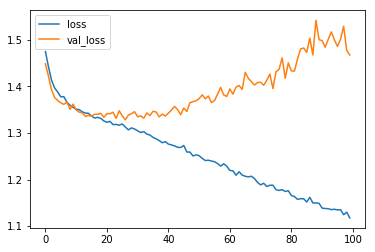

In [22]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.plot()


[]

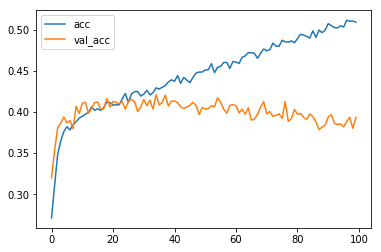

In [21]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.plot()


#### Evaluate our test set and find out Cohen's  quadratic weighte kappa for both Train and Test

In [23]:
model.evaluate(X_test, y_test)

2999/2999 [==============================] - 0s 83us/step


[1.5147559501680385, 0.36345448487796317]

In [24]:
test_pred = model.predict(X_test)
kappa(y_test, test_pred)

0.2650462534737945

In [25]:
train_pred = model.predict(X_train)
kappa(y_train, train_pred)

0.4845347662006966

#### Load out best model and check metrics

In [26]:
model.load_weights('checkpoints/weights_image_categorcial.hdf6')

test_pred = model.predict(X_test)
kappa(y_test, test_pred)

0.30693452876387506

In [27]:
train_pred = model.predict(X_train)
kappa(y_train, train_pred)

0.4187479280215278